In [1]:
# Step 1: Dataset prep (we are going to do all three databased)

In [2]:
# Load libraries

# Core libraries for Python
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# PCA
from sklearn.decomposition import PCA

# K-NN classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Recommendation system
from sklearn.metrics.pairwise import cosine_similarity

# Clustering parts
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Visualization stuffs
import matplotlib.pyplot as plt
import seaborn as sns

# Im bringing in suppress warnings too
import warnings
warnings.filterwarnings('ignore') # Just so our outputs are cleaner...

In [3]:
# start by loading the data
wine_df = pd.read_csv('data/wine_data.csv')
chickwts_df = pd.read_csv('data/chickwts_data.csv')
arrests_df = pd.read_csv('data/arrests_data.csv')

# for debugging:
# print("Loaded")

In [4]:
# Inspection for each dataset, and Standardization of Numeric Features

In [5]:
# Wine Dataset
wine_df.info()
wine_df.describe()
wine_df.head()
wine_df.isnull().sum()

# Sep features and target
X_wine = wine_df.drop("target", axis=1)
y_wine = wine_df["target"]

# Standardize features
wine_scaler = StandardScaler()
X_wine_scaled = wine_scaler.fit_transform(X_wine)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [6]:
# Chickwts Dataset
chickwts_df.info()
chickwts_df.describe()
chickwts_df.head()
chickwts_df.isnull().sum()

# Extract numeric features excluding "feed_name"
chickwts_features = chickwts_df.drop(columns = ["feed_name"])

# Standardize
chickwts_scaler = StandardScaler()
chickwts_scaled = chickwts_scaler.fit_transform(chickwts_features)

# I am also going to go ahead and save the feed names for later
feed_labels = chickwts_df["feed_name"].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   feed_name            100 non-null    object 
 1   proteinContent       100 non-null    float64
 2   fatContent           100 non-null    float64
 3   fiberContent         100 non-null    float64
 4   calciumContent       100 non-null    float64
 5   phosphorusContent    100 non-null    float64
 6   moistureContent      100 non-null    float64
 7   ashContent           100 non-null    float64
 8   metabolizableEnergy  100 non-null    int64  
 9   lysineContent        100 non-null    float64
 10  methionineContent    100 non-null    float64
 11  particleSize         100 non-null    float64
 12  density              100 non-null    float64
 13  price                100 non-null    float64
 14  shelfLife            100 non-null    int64  
 15  weight               100 non-null    floa

In [7]:
# Arrests Dataset
arrests_df.info()
arrests_df.describe()
arrests_df.head()
arrests_df.isnull().sum()

# Drop the unnamed column
arrests_cleaned = arrests_df.drop(columns = ["Unnamed: 0"])

# Standardize from there
arrests_scaler = StandardScaler()
arrests_scaled = arrests_scaler.fit_transform(arrests_cleaned)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [8]:
# Encoding because it will be helpful later down the road
label_encoder = LabelEncoder()
chickwts_df["feed_encoded"] = label_encoder.fit_transform(chickwts_df["feed_name"])

# lets hope this makes stuff easier at least

In [9]:
# Step 2: KNN Classification on Wine

In [10]:
# Apply PCA to X_Wine_scaled to retain 95% of variance

# Initializing PCA
pca = PCA(n_components = 0.95)
X_wine_pca = pca.fit_transform(X_wine_scaled) # bug here, used X_wine instead of X_wine_scaled

# Lets check how many comp it ended up keeping
print(f"Original feature count: {X_wine_scaled.shape[1]}")
print(f"Reduced feature count: {X_wine_pca.shape[1]}")

Original feature count: 13
Reduced feature count: 10


In [11]:
# Establish train-test-split
# Splitting the PCA data features and original target
X_train, X_test, y_train, y_test = train_test_split(
    X_wine_pca, y_wine, test_size = 0.2, random_state = 42, stratify = y_wine # I think this is right??
)

# confirm the shape?
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 142 samples
Test set size: 36 samples


In [12]:
# Grid search and tuning.

# param grid
param_grid = {
    "n_neighbors": [1,3,5,7,9], # completely forgot the comma here... :(
    "weights": ["uniform", "distance"],
}

# Startup the base model
knn = KNeighborsClassifier()

# Run GridSearch with 5-fold cross-val
grid_search = GridSearchCV(knn, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

# Get best params and best CV acc
best_params = grid_search.best_params_
best_cv_accuracy = grid_search.best_score_

# Output the results
print(f"Best parameters: {best_params}")
print(f"Best score: {best_cv_accuracy:.4f}")

Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
Best score: 0.9793


In [13]:
# Fit the best KNN model and get our predictions

# Train the final knn model with best params
final_knn = KNeighborsClassifier(n_neighbors = best_params["n_neighbors"], weights = best_params["weights"])
final_knn.fit(X_train, y_train) # to separate this or not to sep this...

# Predict on test set from the split
y_pred = final_knn.predict(X_test)

In [14]:
# Time to eval the model

# Acc score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# I think its borderline overfitting but Im going to say its not because our CV acc is really high.
# I think out test acc is a little too perfect, but I dont think it should be an issue.

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



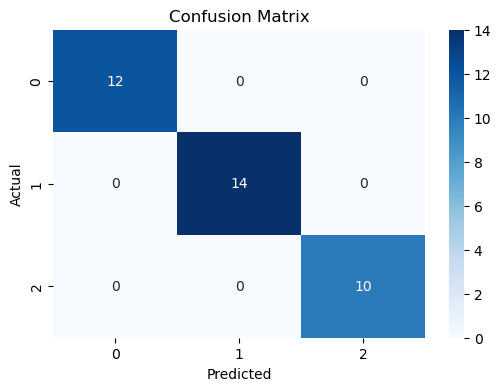

In [15]:
# Visualization
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, cmap = "Blues", fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

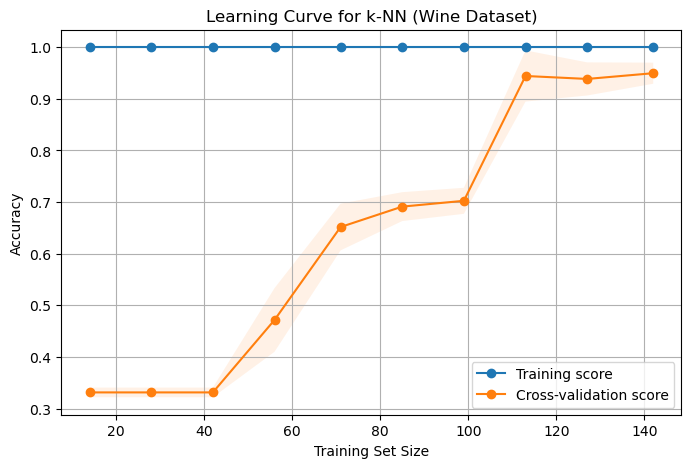

In [16]:
# Just to make sure nothing is weird, Im going to try to make a learning curve using sklearn. Bear with me!
from sklearn.model_selection import learning_curve

# Restart best K-NN model
knn_final = KNeighborsClassifier(n_neighbors = best_params["n_neighbors"], weights = best_params["weights"])

# Start creating the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    knn_final, X_wine_pca, y_wine, cv = 5, scoring = "accuracy", train_sizes = np.linspace(0.1, 1.0, 10), random_state = 42
) # pray it works

# Calculate the mean and deviation
train_mean = np.mean(train_scores, axis = 1)
train_deviation = np.std(train_scores, axis = 1)
val_mean = np.mean(val_scores, axis = 1)
val_deviation = np.std(val_scores, axis = 1)

# try to plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_deviation, train_mean + train_deviation, alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_deviation, val_mean + val_deviation, alpha=0.1)
plt.title("Learning Curve for k-NN (Wine Dataset)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# please work!
# Verdict: looks good! I think?

In [17]:
# Moving on to Chickwts

In [18]:
# Applying PCA to Reduce to 1 comp
pca_chickwts = PCA(n_components = 1) # set to 1 this time
chickwts_pca = pca_chickwts.fit_transform(chickwts_scaled) # picked the most confusing variables... -_-

# Create a dataframe to combine with feed labels
chickwts_pca_df = pd.DataFrame(chickwts_pca, columns=["PC1"])
chickwts_pca_df["feed_name"] = feed_labels  # debug fixed!

# Check the result
chickwts_pca_df.head()

# lets check the results
chickwts_pca_df.head()

,PC1,feed_name
0,2.165341,FirstPeck
1,-0.437253,ChickStart Plus
2,1.194280,EarlyGrow Formula
3,0.247816,HatchMate Premier
4,-0.956156,PeepNourish


In [19]:
# Compute avg vect for each feed and cosine sim matrix

# Group by feed_name and comp avg PC1 value for each feed
feed_vectors = chickwts_pca_df.groupby("feed_name").mean()

# Compute cosine sim between avg vect
similarity_matrix = cosine_similarity(feed_vectors) # I think this is right? Sorry for questioning in these comments.

# Convert this to a dataframe for viewing
similarity_df = pd.DataFrame(similarity_matrix, index = feed_vectors.index, columns = feed_vectors.index)

# Show the matrix
similarity_df

# Also putting this here because it is interesting to see it anyway
# similarity_df.head()

feed_name,BabyBirdBlend,BreederAdvance Complete,BreederChoice Complete,BreederElite Complete,BreederOptimal Formula,BreederPerfect Plus,BreederPrime Formula,BreederVital Premium,BroilerBoost Supreme,BroilerBulk Ultra,...,ReproMax Enhanced,ReproNutrient Formula,ReproSuccess Formula,ShellBuilder Pro,ShellMax Enhanced,ShellStrength Pro,StartRight Formula,TeenChick Formula,WeightGain Pro,YolkPerfect Premium
feed_name,,,,,,,,,,,,,,,,,,,,,
BabyBirdBlend,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
BreederAdvance Complete,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
BreederChoice Complete,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
BreederElite Complete,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
BreederOptimal Formula,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ShellStrength Pro,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
StartRight Formula,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
TeenChick Formula,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0


In [20]:
# Recommendation System
# Create the function to recommend similar feeds

def recommend_feeds(feed_name, top_n=3):
    if feed_name not in similarity_df.columns:
        print(f"Feed '{feed_name}' not found in similarity matrix.")
        return

    recommendations = similarity_df[feed_name].sort_values(ascending=False)[1:top_n+1]

    # Convert to a DataFrame with clear column name because the original output frustrates me
    recommendations_df = recommendations.reset_index()
    recommendations_df.columns = ['Recommended Feed', 'Similarity Score']

    return recommendations_df

# Test
# recommend_feeds("BabyBirdBlend", top_n = 3)

print("Top 3 recommended feeds similar to 'BabyBirdBlend':")
print(recommend_feeds("BabyBirdBlend", 3))

# That looks a lot better!

Top 3 recommended feeds similar to 'BabyBirdBlend':
     Recommended Feed  Similarity Score
0  LayerLuxe Complete               1.0
1  MeatYield Advanced               1.0
2    MeatMax Complete               1.0


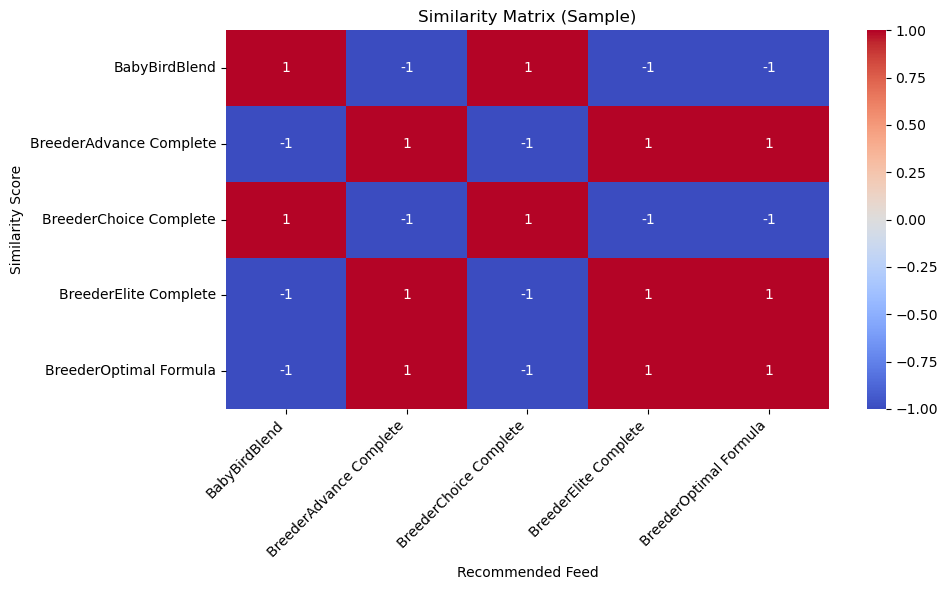

In [21]:
# Heatmap of Similarity matrix
# More stats better

plt.figure(figsize = (10,6))
sns.heatmap(similarity_df.iloc[:5, :5], cmap = "coolwarm", annot = True)
plt.xlabel("Recommended Feed")
plt.ylabel("Similarity Score")
plt.title("Similarity Matrix (Sample)")
plt.xticks(rotation = 45, ha = "right")
plt.yticks (rotation = 0)
plt.tight_layout()
plt.show()

# Thats better. Its not a mil lines squished together!


In [22]:
# USArrests Dataset

In [23]:
# We need to pick the top 3 most relevant features from the USArrests dataset for clustering.
# I think I am going to try to use "Murder", "Assault", "Rape" as these give 3 different aspects of US crime.

selected_features = ["Murder", "Assault","Rape"]
arrests_selected =arrests_cleaned[selected_features]

# Confirm the selection by printing the head()
arrests_selected.head()

,Murder,Assault,Rape
0,13.2,236,21.2
1,10.0,263,44.5
2,8.1,294,31.0
3,8.8,190,19.5
4,9.0,276,40.6


In [24]:
# PCA time...
pca_arrests = PCA(n_components = 2)
arrests_pca = pca_arrests.fit_transform(arrests_selected)

# Im going to go ahead and check the shape and explained variance just in case
print(f"Reduced Shape: {arrests_pca.shape}")
print(f"Explained variance: {pca_arrests.explained_variance_ratio_}") # major debugging on this line. if you use arrests_pca it errors out!

Reduced Shape: (50, 2)
Explained variance: [0.99214611 0.00690011]


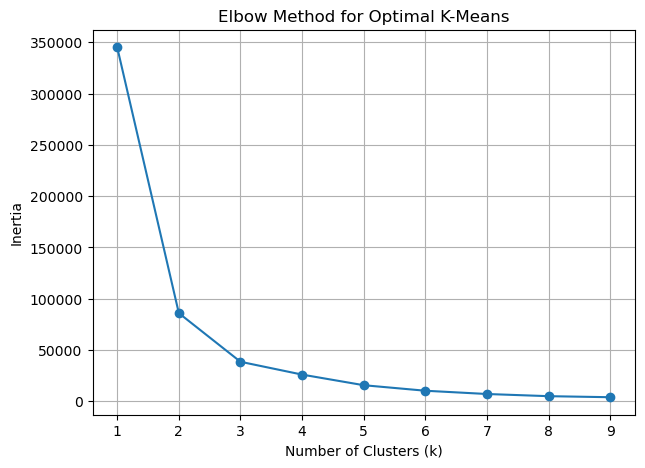

In [25]:
# Try different values of K and store inertia data
inertia = [] # start an empty list
k_range = range(1,10) # one of the few times I feel like I have used range surprisingly

# create the for loop
for k in k_range:
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42) # dont forget random_state
    kmeans.fit(arrests_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve so that we can collect data
plt.figure(figsize = (7,5))
plt.plot(k_range, inertia, marker = "o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K-Means")
plt.grid(True)
plt.show()

# Elbow point: k = 3

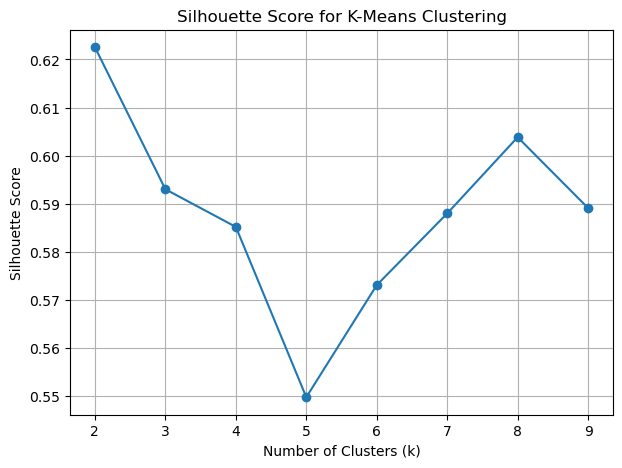

In [26]:
# Lets plot silhouette scores just because im curious
from sklearn.metrics import silhouette_score  # re-import in case it was overwritten
silhouette_scores = []

for k in range(2, 10):  # silhouette score is undefined for k = 1
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
    cluster_labels = kmeans.fit_predict(arrests_pca)
    score = silhouette_score(arrests_pca, cluster_labels)
    silhouette_scores.append(score)

# Plot the scores
plt.figure(figsize = (7,5))
plt.plot(range(2, 10), silhouette_scores, marker = "o")
plt.title("Silhouette Score for K-Means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [27]:
# Now lets move on to GMM
bic_scores = []
aic_scores = [] # I was originally only going to do bic but decided to do aic too
n_components_range = range(1,10)

for n in n_components_range:
    gmm = GaussianMixture(n_components = n, random_state = 42)
    gmm.fit(arrests_pca)
    bic_scores.append(gmm.bic(arrests_pca))
    aic_scores.append(gmm.aic(arrests_pca))



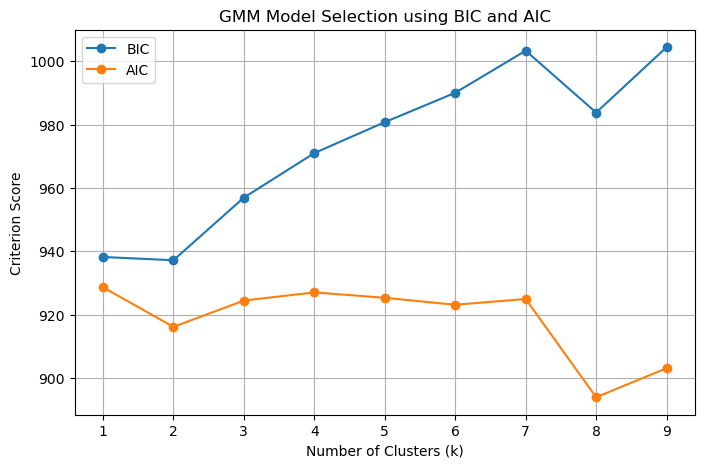

In [28]:
# Visualize the scores
plt.figure(figsize = (8,5))
plt.plot(n_components_range, bic_scores, label = "BIC", marker = "o")
plt.plot(n_components_range, aic_scores, label = "AIC", marker = "o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Criterion Score") # remember lower is better
plt.title("GMM Model Selection using BIC and AIC")
plt.legend()
plt.grid(True)
plt.show()

# This is interesting because BIC should suggest 2. AIC on the other hand is suggesting 8 and then increases again.
# We are going to go with BIC for simplicity

In [29]:
# We can now fit and apply the k-means and GMM with the data we got above
# K-Means = 3
# GMM = 2 from bic chart

# Fitting with K-Means
kmeans_final = KMeans(n_clusters = 3, n_init = 10, random_state = 42)
kmeans_labels = kmeans_final.fit_predict(arrests_pca)

# Fitting with GMM
gmm_final = GaussianMixture(n_components = 2, random_state = 42)
gmm_labels = gmm_final.fit_predict(arrests_pca)

# Additional labels for df for plotting
cluster_df = pd.DataFrame(arrests_pca, columns = ["PC1", "PC2"])
cluster_df["KMeans_Cluster"] = kmeans_labels
cluster_df["GMM_Cluster"] = gmm_labels

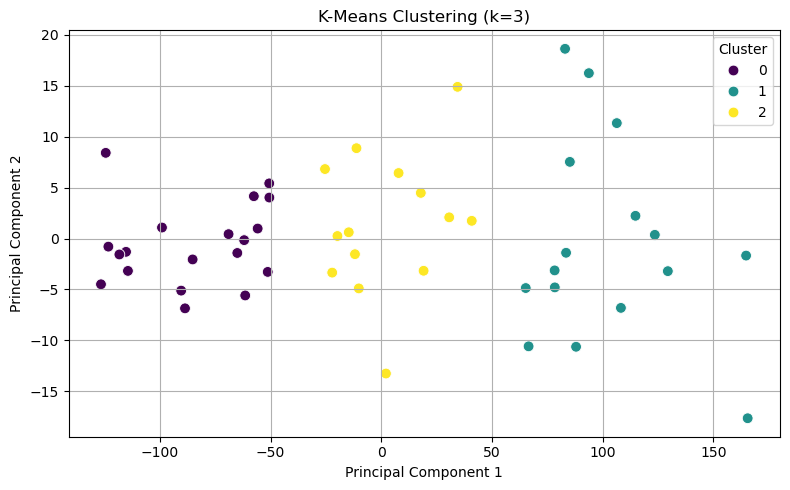

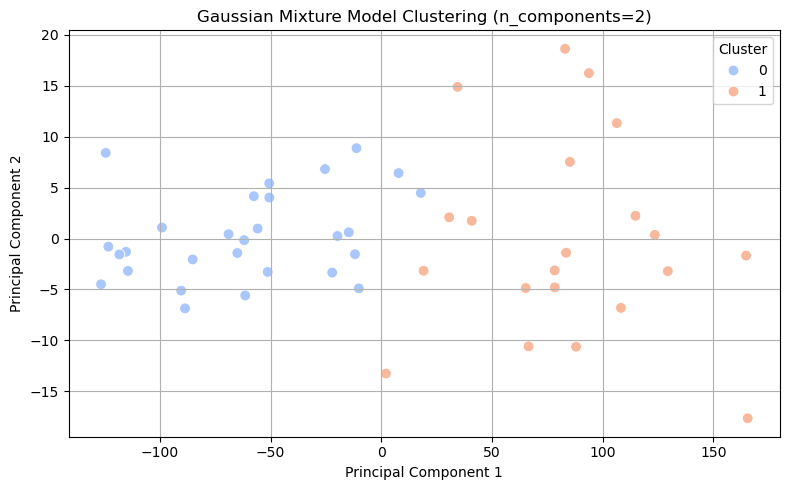

In [30]:
#K-Means cluster plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="KMeans_Cluster", palette="viridis", s=60)
plt.title("K-Means Clustering (k=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# GMM Cluster Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="GMM_Cluster", palette="coolwarm", s=60)
plt.title("Gaussian Mixture Model Clustering (n_components=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
"""
 Conclusion:

# In the wine classification task, PCA was used to reduce dimensionality before training the K-NN classifier model. The model was able to achieve perfect test acc (100%) and a pretty strong cross-val acc. I then used a learning curve and confusion matrix to test to see if I was overfitting.
# For the recommendation system use the chickwts data, PCA and cosine sim allowed us to get effective feed comparisons without anything to crazy happening. The system provides clear and interpretable recommendations (trust me it didnt originally and I had to fix it), and is supported by a cosine sim matrix and heatmap to visualize the recommendations relationships.
# Lastly for the US Arrests clustering task, both K-Means and GMM were applied after I used PCA reduction. The Elbow method and silhouette score indicated that 3 clusters were optimal for k-means. For GMM, I used BIC and AIC, which suggested 2 components and 8 components were optimal. I ended up going with 2 as indicated by BIC. Finally, during the cluster visualization, we were able to confirm that both models effectively seperated the regions based on crime patterns.

# Overall, I think this was really good. I hope you enjoyed looking through it!

"""



'\n Conclusion:\n\n# In the wine classification task, PCA was used to reduce dimensionality before training the K-NN classifier model. The model was able to achieve perfect test acc (100%) and a pretty strong cross-val acc. I then used a learning curve and confusion matrix to test to see if I was overfitting.\n# For the recommendation system use the chickwts data, PCA and cosine sim allowed us to get effective feed comparisons without anything to crazy happening. The system provides clear and interpretable recommendations (trust me it didnt originally and I had to fix it), and is supported by a cosine sim matrix and heatmap to visualize the recommendations relationships.\n# Lastly for the US Arrests clustering task, both K-Means and GMM were applied after I used PCA reduction. The Elbow method and silhouette score indicated that 3 clusters were optimal for k-means. For GMM, I used BIC and AIC, which suggested 2 components and 8 components were optimal. I ended up going with 2 as indica